In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math 
import statsmodels.api as sm
import sklearn
from sklearn.neighbors import KernelDensity
from scipy.integrate import dblquad

Welcome to JupyROOT 6.10/09


In [2]:
samples = ["ggHH_SM.root", "TT.root"]# ,"DYJetsToLL_M-50.root","Wjets.root"]
path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/eventTuples/"
#path = "/Users/Tita/Desktop/files_school/"
sample_name = {"ggHH_SM.root": "Signal", "TT.root" : "TT"}
sample_files = {"Signal" : "ggHH_SM.root", "TT": "TT.root"}

data = {}
for sample in samples:
    #print(sample)
    file = ROOT.TFile.Open(path+sample)
    tauTau = file.Get("tauTau")
    
    #hist_mass = ROOT.TH2D("hist_mass_"+sample,"2D hist mass", 250, 0, 500, 250, 0, 500);
    
    events = np.zeros((tauTau.GetEntries(), 2))
    n = 0
    for event in tauTau :
        bb_cand = event.jets_p4[0] + event.jets_p4[1]
        events[n, 0] = bb_cand.M()
        events[n, 1] = event.SVfit_p4.M()
        n += 1
    data[sample] = events

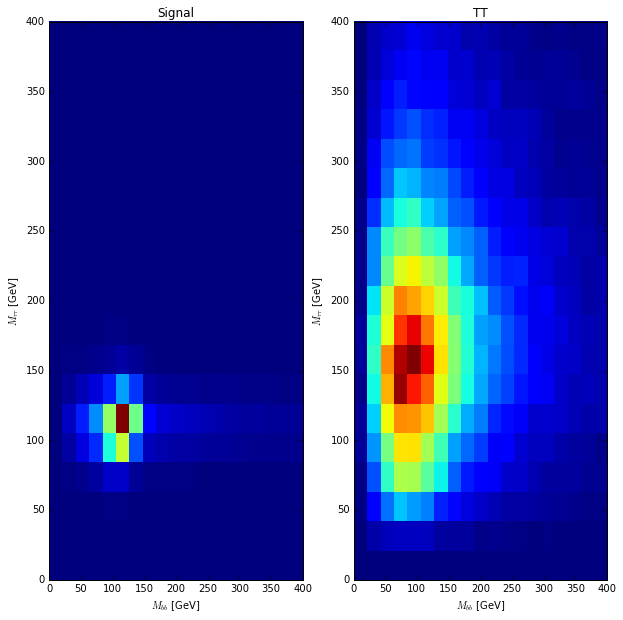

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

n = 0
bins_x = np.linspace(0, 400, 20)
bins_y = np.linspace(0, 400, 20)
for sample, events in data.items():
    ax[n].hist2d(events[:, 0], events[:, 1], bins=[bins_x, bins_y])
    ax[n].set_xlabel(r'$M_{bb}$ [GeV]')
    ax[n].set_ylabel(r'$M_{\tau\tau}$ [GeV]')
    ax[n].set_title(sample_name[sample])
    
    n += 1
#plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)
plt.show()

In [4]:
class EllipseMinimization( ROOT.TPyMultiGenFunction ):
    def __init__( self, data) : #what_to_fit, a, b, x0, y0):
        #self.data = data
        #self.a = param0
        #self.b = param1
        #self.x0 = param2
        #self.y0 = param3
        ROOT.TPyMultiGenFunction.__init__( self, self )

    def NDim(self):
        print('PYTHON NDim called')
        return 4

    def DoEval(self, args):
        x0 = args[0]
        a = args[1]
        y0 = args[2]
        b = args[3]
        
        n_signal = self.CalcNumEvents('ggHH_SM.root', x0, a, y0, b)
        n_bkg = self.CalcNumEvents('TT.root', x0, a, y0, b)
        
        #target = n_signal / math.sqrt(n_bkg) # better formula
        #Discovery sensitivity for a counting experiment with background uncertainty
        #target = math.sqrt(2*((n_signal+n_bkg)*math.log(1 + (n_signal/n_bkg)) - n_signal))
        target = n_signal/math.sqrt(n_signal+n_bkg)
        print("target = ", target)
        return target
    
    def CalcNumEvents(self, sample, x0, a, y0, b):
        events = data[sample]
        x = events[:, 0]
        y = events[:, 1]
        weight = events[:, 2]
        weight_total = np.sum(weight)
        inside_ellipse = (((x-x0)**2) / (a*a) + ((y-y0)**2)/(b*b)) < 1
        n_inside = np.sum(inside_ellipse * weight)
        print("params: ", x0, a, y0, b)
        print(sample, " num entries: ", np.count_nonzero(inside_ellipse))
        return n_inside / weight_total
        
    
def FindParams(x0, a, y0, b, data):
    min = ROOT.Math.Factory.CreateMinimizer("Minuit", "Combined")
    #min.SetMaxFunctionCalls(1000000)
    #min.SetMaxIterations(100000)
    #min.SetTolerance(0.001)
    min.SetPrintLevel(2)
    ellipse = EllipseMinimization(data)

    step = [10,10,10,10]
    variable = [x0,a,y0,b]

    min.SetFunction(ellipse)

    # Set the free variables to be minimized!
    min.SetVariable(0,"x0",variable[0], step[0])
    min.SetVariable(1,"a",variable[1], step[1])
    min.SetVariable(2,"y0",variable[2], step[2])
    min.SetVariable(3,"b",variable[3], step[3])
    
    min.Minimize()
    
    x0 = min.X()[0]
    a = min.X()[1]
    y0 = min.X()[2]
    b = min.X()[3]
    
    
    print("Final", x0, a, y0, b)
    

In [5]:
mean = np.mean(data[sample_files["Signal"]], axis=0)
print(mean[0])
print(mean[1])

159.96306146787208
117.04371164725576


In [6]:
std = np.std(data[sample_files["Signal"]], axis=0)
std

array([167.85582204,  40.32194555])

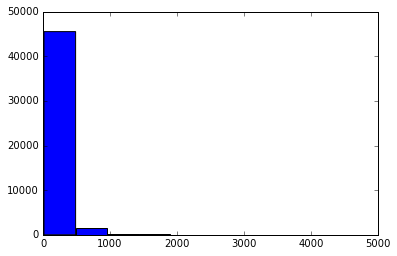

In [7]:
plt.hist(data[sample_files["Signal"]][:, 0])
plt.show()

In [8]:
np.std(data[sample_files["Signal"]][:, 0])

167.85582204451285

In [9]:
FindParams(mean[0], 40, mean[1], 40, data)

PYTHON NDim called


IndexError: index 2 is out of bounds for axis 1 with size 2

Exception: bool TMinuitMinimizer::Minimize() =>
    Failure in TPyMultiGenFunction::DoEval (C++ exception of type runtime_error)

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 x0           1.59963e+02  1.00000e+01     no limits
     2 a            4.00000e+01  1.00000e+01     no limits
     3 y0           1.17044e+02  1.00000e+01     no limits
     4 b            4.00000e+01  1.00000e+01     no limits
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD           0        0.01
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.


In [10]:
ellipse = EllipseMinimization(data)

In [20]:
ellipse.CalcNumEvents(sample_files["Signal"], 151.907, 10, 112.916, 10)

num entries:  650


0.014418639412300904

In [21]:
ellipse.CalcNumEvents(sample_files["TT"], 151.907, 876426,  112.916, 148022)

num entries:  54379


1.0

In [22]:
data[sample_files["Signal"]].shape

(45803, 3)

In [12]:
#dens = sm.nonparametric.KDEUnivariate(data[sample_files["Signal"]][:, 0])
dens = KernelDensity(bandwidth=5, kernel='epanechnikov')
#dens.fit(data[sample_files["Signal"]][:, 0].reshape(-1, 1))
dens.fit(data[sample_files["Signal"]])

dens_map = {}
for sample, events in data.iteritems():
    dens_map[sample] = KernelDensity(bandwidth=5, kernel='tophat')
    dens_map[sample].fit(events)

In [16]:
bins = np.linspace(50, 150, 1000)

#plt.scatter(bins, np.exp(dens.score_samples(bins.reshape(-1, 1))))
print(dens_map[sample_files["Signal"]].shape)
plt.scatter(bins, np.exp(dens_map[sample_files["Signal"]].score_samples(bins.reshape(1, -1))))
plt.show()

AttributeError: 'KernelDensity' object has no attribute 'shape'

In [3]:
sklearn.__version__

'0.18.1'

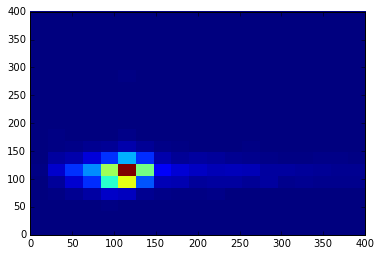

In [14]:
bins = np.linspace(50, 150, 100)
#sample = dens.sample(10000)
sample = dens_map[sample_files["Signal"]].sample(10000)
bins_x = np.linspace(0, 400, 20)
bins_y = np.linspace(0, 400, 20)
plt.hist2d(sample[:,0],sample[:,1],bins=[bins_x,bins_y])
plt.show()

In [20]:
math.exp(dens.score(np.array([100, 100]).reshape(1, -1)))

0.000185972468699313

In [16]:
def fn_sqrt(x):
    return ...

dblquad(lambda x, y: math.exp(self.dens[sample].score(np.array([x, y]).reshape(1, -1))), x0-a, x0,
        lambda x: -math.sqrt(1- ((x - 100) / 20) ** 2),
        lambda x: y0 + fn_sqrt(x)

(3.1415926535897967, 2.000470900043183e-09)